## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import learning_curve,cross_val_score,validation_curve,train_test_split,KFold

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor,plot_importance
import joblib


In [3]:
#functions
def remove_by_vif(X,vif=5):
    """Remove columns from X whose VIF is greater than supplied 'vif'
    Parameters:
        X:array or dataframe containing data excluding target variable
        vif: int or float of limiting value of VIF
    Note:
        This function changes X inplace
    """
    import statsmodels.api as sm
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    
    removed=[]
    for i in range(len(X.columns)):
        l = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        s=pd.Series(index=X.columns,data=l).sort_values(ascending=False)
        if s.iloc[0]>vif:
            X.drop(s.index[0],axis=1,inplace=True)
            print(s.index[0],', VIF: ',s.iloc[0])
            removed.append(s.index[0])
        else:
            break
    return removed
            
def plot_validation_curve(scores,param_range,param_name,scoring='r2'):
    """This function plot validation curve.
    
    Parameters:
        scores: scores obtained from validation_curve() method
        param_range: list of range of parameters passed as 'param_range' in validation_curve() method
        scoring: str
    """
    n=len(param_range)
    if scoring=='r2':
        train_score=[scores[0][i].mean() for i in range (0,n)]
        test_score=[scores[1][i].mean() for i in range (0,n)]
    elif scoring=='neg_mean_squared_error':
        train_score=[np.sqrt(-scores[0][i].mean()) for i in range (0,n)]
        test_score=[np.sqrt(-scores[1][i].mean()) for i in range (0,n)]

    fig=plt.figure(figsize=(8,6))
    plt.plot(param_range,train_score,label='Train')
    plt.plot(param_range,test_score,label='Test')
    plt.xticks=param_range
    plt.title("Validation curve of {}".format(param_name),size=12)
    plt.legend()

## EDA and Feature Engineering

In [4]:
data=pd.read_csv('data/train_NIR5Yl1.csv')

In [5]:
data.head()

,ID,Tag,Reputation,Answers,Username,Views,Upvotes
0,52664,a,3942.0,2.0,155623,7855.0,42.0
1,327662,a,26046.0,12.0,21781,55801.0,1175.0
2,468453,c,1358.0,4.0,56177,8067.0,60.0
3,96996,a,264.0,3.0,168793,27064.0,9.0
4,131465,c,4271.0,4.0,112223,13986.0,83.0


**Tag** and **Username** are categorical variables. Rest are numberical variables.

Also, no null values are present in data

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330045 entries, 0 to 330044
Data columns (total 7 columns):
ID            330045 non-null int64
Tag           330045 non-null object
Reputation    330045 non-null float64
Answers       330045 non-null float64
Username      330045 non-null int64
Views         330045 non-null float64
Upvotes       330045 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.6+ MB


In [7]:
# Check unique counts of each column
for col in data.columns:
    print(col, data[col].nunique())

ID 330045
Tag 10
Reputation 16527
Answers 63
Username 141802
Views 82137
Upvotes 7239


### Tagwise sum of upvotes and answers

In [8]:
sum_df=data.groupby(by='Tag').sum()
avg_df=data.groupby(by='Tag').mean()

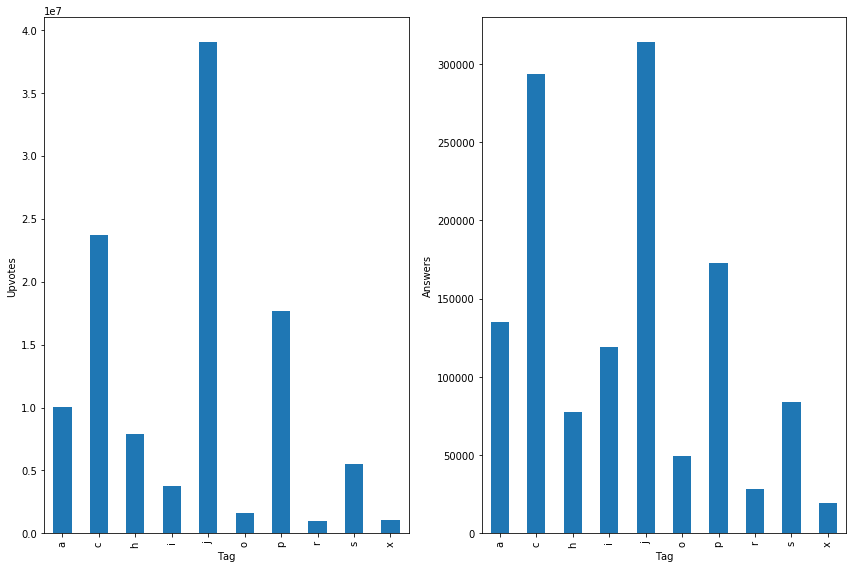

In [9]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
sum_df['Upvotes'].plot(kind='bar',cmap='tab20')
plt.ylabel('Upvotes')
plt.subplot(1,2,2)
sum_df['Answers'].plot(kind='bar',cmap='tab20')
plt.ylabel('Answers')
plt.tight_layout()

### Checking correlations

In [10]:
corr_matrix=data[['Reputation', 'Answers', 'Username', 'Views', 'Upvotes']].corr()

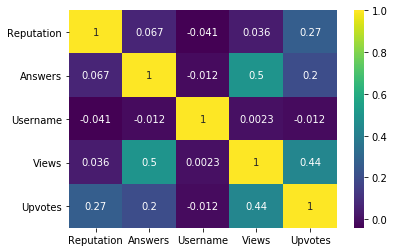

In [11]:
#no highly correlated features
#username is not at all correlated with any feature
#it has a lot of unique values. It can be ignored
sns.heatmap(corr_matrix,cmap='viridis',annot=True)

### Feature Engineering

As features are very less, not much feature engineering can be done.
I've done following feature engineering:
1. Polynomial features from numerical features
2. One hot encoding of **Tag**
3. Tag-wise mean of numberical features
4. Removing some features with high variance inflation factor. This step is necessary of Linear Regression model.

In [12]:
data=pd.read_csv('data/train_NIR5Yl1.csv')

In [13]:
num_features=['Reputation', 'Answers', 'Views']

In [14]:
#1. Getting polynomial features and selecting only newly created features
poly=PolynomialFeatures(degree=2,include_bias=False)
tmp=pd.DataFrame(poly.fit_transform(data[num_features])).loc[:,len(num_features):]
data=data.join(tmp)

In [15]:
# data['Reputation_Views']=data['Reputation']*data['Views']

In [16]:
#2. Tag-wise mean of numberical features
tmp=data.groupby('Tag')[num_features].mean()
tmp.columns=tmp.columns+'_mean'
data=pd.merge(data,tmp.reset_index(),how='left',on='Tag')

In [17]:
# Username wise count of upvotes. Fill nulls with 0
uname_count=data.groupby('Username')['Upvotes'].count().reset_index()
uname_count.rename(columns={'Upvotes':'User_Upvote_Count'},inplace=True)
data=pd.merge(data,uname_count,how='left',on='Username')
data['User_Upvote_Count'].fillna(0,inplace=True)

In [18]:
data['uv']=data['Upvotes']/data['Views']
uname_uv=data.groupby('Username')['uv'].mean().reset_index()
uname_uv.rename(columns={'uv':'User_Upvote_Views_Mean'},inplace=True)
data=pd.merge(data,uname_uv,how='left',on='Username')
data['User_Upvote_Views_Mean'].fillna(0,inplace=True)

data.drop('uv',axis=1,inplace=True)

In [19]:
#3. One hot encoding of Tag
dummies=pd.get_dummies(data['Tag'],drop_first=True)
data=pd.concat([data,dummies],axis=1)
data.drop('Tag',axis=1,inplace=True)

In [20]:
X=data.drop('Upvotes',axis=1)
y=data['Upvotes']

In [21]:
#4. Check multicolinearity
removed_by_vif=remove_by_vif(X.copy())
# removed_by_vif=['p','j','c']
X=X.drop(removed_by_vif,axis=1)

C:\Users\Asus\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


x , VIF:  inf
p , VIF:  inf
Views_mean , VIF:  78.69947049411702
7 , VIF:  9.242162326633581
Reputation_mean , VIF:  8.408038205010403


In [22]:
X.drop('ID',axis=1,inplace=True)

### Train Test Split

* I have made 3 splits of data : Train, Validation and Test
* Performed standard scaling

In [23]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)

In [24]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=60)

In [25]:
# #remove outliers based on Upvotes
# index=y_train[y_train<50000].index
# X_train=X_train.loc[index]
# y_train=y_train.loc[index]

In [26]:
# #Transform features

# X_train['Views']=X_train['Views'].apply(lambda x: np.log1p(x)**3.5)
# X_train['Reputation']=X_train['Reputation'].apply(lambda x: np.log1p(x)**3)

In [27]:
#scaling
std=StandardScaler()
X_train_scaled=pd.DataFrame(std.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_val_scaled=pd.DataFrame(std.transform(X_val),columns=X_val.columns,index=X_val.index)
X_test_scaled=pd.DataFrame(std.transform(X_test),columns=X_test.columns,index=X_test.index)

## ML
I have trained following models
1. Linear Regression
2. XGBoost
3. Stacking of Linear Regression and XGBoost

In [28]:
scoring='neg_mean_squared_error'

### Linear Regression

In [29]:
lr=LinearRegression()
scores=cross_val_score(lr,X_train_scaled,y_train,n_jobs=-1,cv=5,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  1382.5789418388047


In [30]:
lr.fit(X_train_scaled,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [31]:
# Result on test
y_train_pred=lr.predict(X_train_scaled)
y_val_pred=lr.predict(X_val_scaled)
y_pred_lr=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 1240.5542283011553
Test RMSE: 788.5061248540156


### XGB

* I have used **Bayesian Optimization** to tune hyperparameters of the model
* XGBoost is over-fitting on data
* Cross-validation score of XGBoost is better than Linear Regression

In [32]:
# Baseline Model
xgb=XGBRegressor(random_state=50)
xgb.fit(X_train_scaled,y_train)
y_train_pred=xgb.predict(X_train_scaled)
y_val_pred=xgb.predict(X_val_scaled)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 611.2439403770467
Test RMSE: 917.6307110584477


In [33]:
# Bayesian Optimization
opt = BayesSearchCV(
    estimator = XGBRegressor(
        n_jobs = -1,
        tree_method='approx'
    ),
    search_spaces = {
        'learning_rate': (0.01, 1.0, 'log-uniform'),
        'min_child_weight': (0, 20),
        'max_depth': (3, 5),
#         'max_delta_step': (0, 20),
        'subsample': (0.1, 1.0, 'uniform'),
        'colsample_bytree': (0.1, 1.0, 'uniform'),
        'colsample_bylevel': (0.1, 1.0, 'uniform'),
        'reg_lambda': (1e-3, 1000, 'log-uniform'),
        'reg_alpha': (1e-3, 1.0, 'log-uniform'),
#         'gamma': (1e-9, 0.5, 'log-uniform'),
        'base_score':((1e-4, 0.5, 'log-uniform'))
    },    
    scoring = scoring,
    cv =3,
    n_jobs = -1,
    refit = True,
    random_state = 42
)

opt.fit(X_train_scaled,y_train)

[23:12:59] Tree method is selected to be 'approx'


BayesSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, tree_method='approx'),
       fit_params=None, iid=True, n_iter=50, n_jobs=-1, n_points=1,
       optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=42,
       refit=True, return_train_score=False,
       scoring='neg_mean_squared_error',
       search_spaces={'learning_rate': (0.01, 1.0, 'log-uniform'), 'min_child_weight': (0, 20), 'max_depth': (3, 5), 'subsample': (0.1, 1.0, 'uniform'), 'colsample_bytree': (0.1, 1.0, 'uniform'), 'colsample_bylevel': (0.1, 1.0, 'uniform'), 'reg_lambda': (0.001, 1000, 'log-uniform'), 'reg_alpha': (0.001, 1.0, 

In [34]:
opt.best_params_

{'base_score': 0.03198482324113894,
 'colsample_bylevel': 0.6992072058798394,
 'colsample_bytree': 0.6224051267215517,
 'learning_rate': 0.11238011005002531,
 'max_depth': 4,
 'min_child_weight': 3,
 'reg_alpha': 0.013926195709085923,
 'reg_lambda': 0.02730503272952669,
 'subsample': 0.6281586354493193}

In [35]:
#Tuned Model
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_scaled,y_train)
y_train_pred=xgb.predict(X_train_scaled)
y_val_pred=xgb.predict(X_val_scaled)
y_pred_xgb=np.append(y_train_pred,y_val_pred)
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 567.3019604832035
Test RMSE: 858.9920844201926


In [36]:
#cross-val-score
xgb=XGBRegressor(random_state=50,**opt.best_params_)
scores=cross_val_score(xgb,X_train_scaled,y_train,n_jobs=-1,cv=3,scoring=scoring)
print('RMSE: ',np.sqrt(-scores).mean())

RMSE:  1239.7525300129541


In [37]:
#Feature importance
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_scaled,y_train)
pd.DataFrame(xgb.feature_importances_,index=X_train.columns).sort_values(0,ascending=False).head()

,0
5,0.211934
Views,0.152263
4,0.130658
Reputation,0.104938
8,0.099794


#### Learning Curve

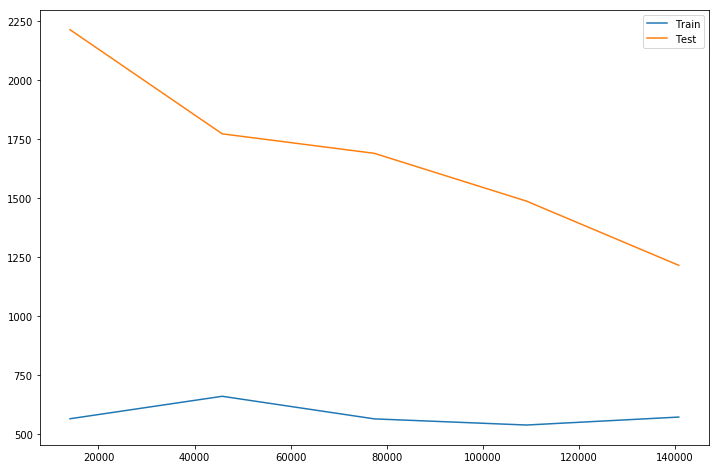

In [38]:
xgb=XGBRegressor(random_state=51,**opt.best_params_)
lc=learning_curve(xgb,X_train_scaled,y_train,cv=3,n_jobs=-1,scoring=scoring)
size=lc[0]
train_score=[-lc[1][i].mean() for i in range (0,5)]
test_score=[-lc[2][i].mean() for i in range (0,5)]
fig=plt.figure(figsize=(12,8))
plt.plot(size,np.sqrt(train_score),label='Train')
plt.plot(size,np.sqrt(test_score),label="Test")
plt.legend()
#Overfit

### Stacking
* Taking simple average of results of Linear Regression and XGBoost model
* This has reduced over-fitting nature of XGBoost

In [39]:
y_pred_stack=(y_pred_lr+y_pred_xgb)/2

In [40]:
y_train_pred=y_pred_stack[:len(y_train)]
y_val_pred=y_pred_stack[len(y_train):]
print('Train RMSE:',np.sqrt(mean_squared_error(y_train,y_train_pred)))
print('Test RMSE:',np.sqrt(mean_squared_error(y_val,y_val_pred)))

Train RMSE: 809.0433669890301
Test RMSE: 792.6400213657131


### Result on test data

In [41]:
X_train_1=pd.concat([X_train_scaled,X_val_scaled])
y_train_1=pd.concat([y_train,y_val])

In [42]:
lr.fit(X_train_1,y_train_1)
y_pred_lr=lr.predict(X_test_scaled)

In [43]:
# XGB
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
xgb.fit(X_train_1,y_train_1)
y_pred_xgb=xgb.predict(X_test_scaled)
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_xgb)))

Test RMSE: 1170.779718791324


In [44]:
#Stack
y_pred_stack=(y_pred_lr+y_pred_xgb)/2
print('Test RMSE:',np.sqrt(mean_squared_error(y_test,y_pred_stack)))

Test RMSE: 939.079370196267


## Submission on Test Data
Generate submission file to submit results on competition website

In [45]:
test=pd.read_csv('data/test_8i3B3FC.csv')

In [46]:
# Data preparation
X_scaled=pd.DataFrame(std.fit_transform(X),columns=X.columns,index=X.index)

# Polynomial Features
tmp=pd.DataFrame(poly.transform(test[num_features])).loc[:,len(num_features):]
test=test.join(tmp)

#Tag wise mean of num features
tmp=test.groupby('Tag')[num_features].mean()
tmp.columns=tmp.columns+'_mean'
test=pd.merge(test,tmp.reset_index(),how='left',on='Tag')

# Userwise upvotes count
test=pd.merge(test,uname_count,how='left',on='Username')
test['User_Upvote_Count'].fillna(0,inplace=True)

# Userwise upvotes,views mean
test=pd.merge(test,uname_uv,how='left',on='Username')
test['User_Upvote_Views_Mean'].fillna(0,inplace=True)

# One hot encoding of Tag
dummies=pd.get_dummies(test['Tag'],drop_first=True)
test=pd.concat([test,dummies],axis=1)
test.drop('Tag',axis=1,inplace=True)

# remove columns with high vif
test_ids=test['ID']
test.drop(['ID']+removed_by_vif,axis=1,inplace=True)

#scaling
test_scaled=pd.DataFrame(std.transform(test),columns=test.columns)

In [47]:
lr=LinearRegression()
xgb=XGBRegressor(random_state=51,n_jobs=-1,**opt.best_params_)
std=StandardScaler()
lr.fit(X_scaled,y)
xgb.fit(X_scaled,y)

XGBRegressor(base_score=0.03198482324113894, booster='gbtree',
       colsample_bylevel=0.6992072058798394,
       colsample_bytree=0.6224051267215517, gamma=0,
       learning_rate=0.11238011005002531, max_delta_step=0, max_depth=4,
       min_child_weight=3, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=51,
       reg_alpha=0.013926195709085923, reg_lambda=0.02730503272952669,
       scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6281586354493193)

In [48]:
y_pred_lr=lr.predict(test_scaled)
y_pred_xgb=xgb.predict(test_scaled)
y_pred_stacked=(y_pred_lr+y_pred_xgb)/2

In [49]:
submission=pd.DataFrame(index=test_ids)
submission['Upvotes']=list(map(int,y_pred_stacked))

In [50]:
submission.to_csv('Submission.csv')